In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re

In [2]:
# read in point source NEI data (EPA regions 1-5)
point_east = pd.read_csv('point_12345.csv', 
                         usecols =['state','fips code','county','zip code','eis facility id',
                                   'company name','site name','naics code','eis unit id',
                                   'eis process id','unit type','unit description',
                                   'design capacity','design capacity uom',
                                   'process description','calc data year'] , 
                         dtype={'company name': 'string', 
                                'zip code': 'string', 
                                'design capacity uom':'string'})

# create column for 3 digit naics code
point_east.loc[:,'naics_sub'] = point_east['naics code'].astype(str).str[:3]

# keep only manufacturing naics
mfg_east = point_east[(point_east.naics_sub.astype(int) >= 311) & 
                      (point_east.naics_sub.astype(int) <= 339)].copy()


# rename columns
mfg_east.rename(columns={"fips code": "fips", "zip code": "zip_code", "eis facility id": "eis_facility_id", 
                         "company name": "company_name", "site name":'site_name', "naics code":'naics_code',
                        "eis unit id":'eis_unit_id', "eis process id":'eis_process_id',"unit type":'unit_type',
                        "unit description":'unit_description',"design capacity":'design_capacity',
                        "design capacity uom":'design_capacity_uom',"process description":'process_description',
                        "calc data year":'calc_data_year'},inplace=True)

# keep only boiler units
blr_east = mfg_east[mfg_east['unit_type']=='Boiler']

# check for boilers under different unit types
others_east = mfg_east[(mfg_east['unit_type']=='Unclassified') |
                      (mfg_east['unit_type']=='Other combustion') | 
                      (mfg_east['unit_type']=='Other process equipment')]

others_east = others_east[(others_east['unit_description'].str.contains('Boiler')) |
                          (others_east['unit_description'].str.contains('boiler'))]


blr_east = blr_east.append(others_east)

# multiple pollutants listed for each unit in a facility, so only keep one of each unit ID
blr_units_east = blr_east.drop_duplicates(subset=['eis_unit_id'])


In [4]:
point_west = pd.read_csv('point_678910.csv',
                         usecols=['state','fips','county','zip_code','eis_facility_id','company_name',
                                  'site_name','naics_code','eis_unit_id','eis_process_id','unit_type',
                                  'unit_description','design_capacity','design_capacity_uom','process_description',
                                  'calc_data_year'],
                         dtype={'company_name':'string',
                                'zip_code':'string',
                                'design_capacity_uom':'string',
                                'process_description':'object'})

point_west.loc[:,'naics_sub'] = point_west['naics_code'].astype(str).str[:3]

mfg_west = point_west[(point_west.naics_sub.astype(int) >= 311) & 
                      (point_west.naics_sub.astype(int) <= 339)].copy()


blr_west = mfg_west[mfg_west['unit_type']=='Boiler']

others_west = mfg_west[(mfg_west['unit_type']=='Unclassifi') |
                      (mfg_west['unit_type']=='Other comb') | 
                      (mfg_west['unit_type']=='Process Eq')]

others_west = others_west[(others_west['unit_description'].str.contains('Boiler')) |
                          (others_west['unit_description'].str.contains('boiler'))]


blr_west = blr_west.append(others_west)


blr_units_west = blr_west.drop_duplicates(subset=['eis_unit_id'])

In [8]:
blr_units = pd.concat([blr_units_east,blr_units_west]).reset_index(drop=True)

In [542]:
def convert_capacity_units(nei_units):
    
    #https://farm-energy.extension.org/energy-conversion-values/
    #https://www.engineeringtoolbox.com/boiler-horsepower-d_1061.html
    unit_conv = {'E6BTU/HR': 1,
                 'E3LB/HR': 1, # 0.970 exact, or 1 for rule of thumb
                 'HP' : 0.0345, # assuming this means boiler hp
                 'BLRHP' : 0.0345,
                 'LB/HR' : 0.002545,
                 'TON/DAY' : 0.083,
                 'FT3/DAY' : 0.001555*10**-3,
                 'KW' : 3.413*10**-3,
                 'MW' :3.413,
                 'TON/HR' : 2,
                 'BTU/HR' : 10**-6,
                 'DATAMIGR': 1,
                 '0':0
                }

    nei_units.design_capacity.fillna('0',inplace=True)
    nei_units.design_capacity_uom.fillna('0',inplace=True)
    
    nei_units.loc[:,'cap_mmbtuhr'] = nei_units.apply(
        lambda x: x['design_capacity']*unit_conv[x['design_capacity_uom']],axis=1)
    
    for i in nei_units[(nei_units.design_capacity_uom =='DATAMIGR')&
                       (nei_units.unit_description.str.contains('MMBTU/HR'))].index:                 
        nei_units.loc[i,'cap_mmbtuhr'] = float(re.findall('\d*\.?\d+', nei_units['unit_description'][i])[0])
    
    for i in nei_units[(nei_units.design_capacity_uom =='DATAMIGR')&
                       (nei_units.process_description.str.contains('MMBTU/HR'))].index: 
        nei_units.loc[i,'cap_mmbtuhr'] = float(re.findall('\d*\.?\d+', nei_units['process_description'][i])[0])
    
    
    return

In [567]:
def get_cap_and_fueltype(nei_units):
    
    nei_units.unit_description.fillna('nan',inplace=True)
    nei_units.process_description.fillna('nan',inplace=True)
    
    nei_units.unit_description = nei_units.unit_description.str.lower()
    nei_units.process_description = nei_units.process_description.str.lower()
    
    # two descriptions that contained 'mmbtu' but didn't have a capacity value, just keep at 0.01
    nei_units.loc[nei_units['eis_facility_id'] == 7731311, 'process_description'] = '0.01'
    nei_units.loc[nei_units['eis_facility_id'] == 7241911, 'process_description'] = '0.01'
    
    # capture capacity information written in description columns    
    for i in nei_units[(nei_units.process_description.str.contains('btu'))&
                       ((nei_units.cap_mmbtuhr==0) | (nei_units.cap_mmbtuhr==0.01))].index:
        nei_units.loc[i,'cap_mmbtuhr'] = float(re.findall('\d*\.?\d+', nei_units['process_description'][i])[-1])

    for i in nei_units[(nei_units.unit_description.str.contains('btu'))&
                       ((nei_units.cap_mmbtuhr==0) | (nei_units.cap_mmbtuhr==0.01))].index:
        nei_units.loc[i,'cap_mmbtuhr'] = float(re.findall('\d*\.?\d+', nei_units['unit_description'][i])[-1])
    
    # make capacity values a float data type
    blr_units['cap_mmbtuhr'] = pd.to_numeric(blr_units['cap_mmbtuhr'], downcast="float")
    
    
    
    # capture fuel type information from descriptions
    nei_units.loc[(nei_units['unit_description'].str.contains('natural gas|natural-gas| ng|-ng'))|
                  (nei_units['process_description'].str.contains('natural gas|natural-gas| ng|-ng')),
                 'fuel_type'] = 'natural gas'
    
    nei_units.loc[(nei_units['unit_description'].str.contains('coal'))|
                  (nei_units['process_description'].str.contains('coal')),
                 'fuel_type'] = 'coal'
    
    nei_units.loc[(nei_units['unit_description'].str.contains(' oil|diesel'))|
                  (nei_units['process_description'].str.contains(' oil|diesel')),
                 'fuel_type'] = 'fuel oil'
    
    nei_units.loc[(nei_units['unit_description'].str.contains('lpg|ngl'))|
                  (nei_units['process_description'].str.contains('lpg|ngl')),
                 'fuel_type'] = 'LPG/NGL'
    
    nei_units.loc[(nei_units['unit_description'].str.contains('coke'))|
                  (nei_units['process_description'].str.contains('coke')),
                 'fuel_type'] = 'coke'
    
    nei_units.loc[(nei_units['unit_description'].str.contains('biomass|wood'))|
                  (nei_units['process_description'].str.contains('biomass|wood')),
                 'fuel_type'] = 'biomass'
    
    
    nei_units.loc[:,'data_source'] = 'NEI'
    
    return

In [576]:
convert_capacity_units(blr_units)
get_cap_and_fueltype(blr_units)

In [579]:
blr_units.to_csv('NEI_boilers.csv',index=False)

In [387]:
def make_histogram_capacity(naics_df,label):
    plt.hist(naics_df['design_capacity'],
             bins=np.logspace(np.log10(0.01),np.log10(1e5), 16),
             log=False, alpha=0.5, color='cadetblue',ec='gray', label=label) #darkseagreen
    
    plt.gca().set_xscale("log")
    plt.xlabel("Design capacity (mmbtu/hr)", size=14, fontname='Arial')
    plt.ylabel("Count", size=14,fontname='Arial')
    plt.xticks(size=13,fontname='Arial')
    plt.yticks(size=13,fontname='Arial')  #np.arange(0, 550, 100),
    plt.title(label,size=14,fontname='Arial')
    #plt.legend(loc='upper right',prop={"family":'Arial',"size":12})

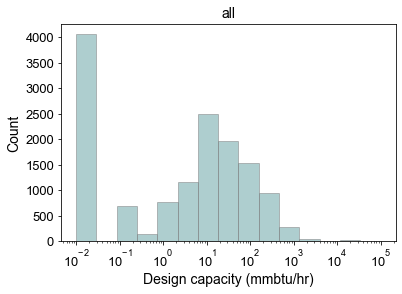

In [388]:
#make_histogram_capacity(blr_units[blr_units.naics_sub=='332'],'332')
make_histogram_capacity(blr_units,'all')

Text(0, 0.5, 'Count')

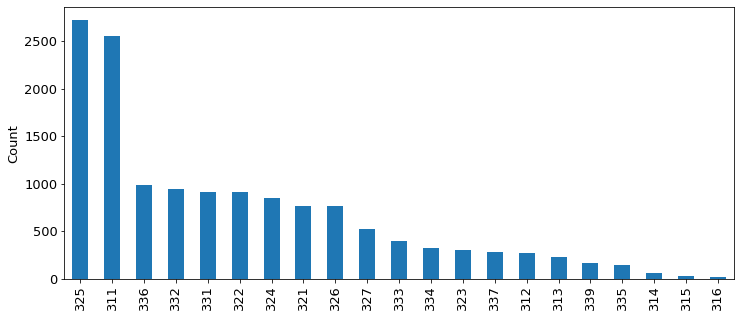

In [296]:
blr_units.naics_sub.value_counts().plot(kind='bar', figsize=(12,5))
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.ylabel("Count",fontsize=13)